# To evaluate decoherence curve from an underlying noise spectrum
Siddharth Dhomkar, Department of Physics, IIT Madras

## Initialise

In [1]:
# Other useful packages:
from plotly.subplots import make_subplots
import numpy as np
from plotly import graph_objs as go
import pandas as pd
from scipy.interpolate import interp1d
from IPython.display import clear_output 
from scipy.optimize import curve_fit
from scipy.interpolate import InterpolatedUnivariateSpline
import copy
import matplotlib
import matplotlib.pyplot as plt

### Figure template

In [2]:
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    # 'opacity': 0.2,
    'xaxis': {
        'title': 'Time (\u03BCs)',
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        },
    'yaxis': {
        'title': 'Coherence',
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 6,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white'
        },
    'font':{'family':'mathjax',
            'size': 22,
            }
}

## Functions to generate coherence curve from a given set of noise spectra

In [3]:
# %%
# Create CPMG-like pulse timing array
def cpmgFilter(n, Tmax):
    tpi = np.empty([n])
    for i in range(n):
        tpi[i]= Tmax*(((i+1)-0.5)/n)
    return tpi


# %%
# Generate filter function for a given pulse sequence
def getFilter(n,w0,piLength,Tmax):
    tpi = cpmgFilter(n,Tmax)
    f = 0    
    for i in range(n):
        f = ((-1)**(i+1))*(np.exp(1j*w0*tpi[i]))*np.cos((w0*piLength)/2) + f

    fFunc = (1/2)*((np.abs(1+((-1)**(n+1))*np.exp(1j*w0*Tmax)+2*f))**2)/(w0**2)
    return fFunc


# %%
# Generate decoherence curve corresponding to a noise spectrum (input shape = variable1.size x w.size)
def getCoherence(S,w0,T0,n,piLength):
    steps = T0.size
    C_invert = np.empty([S.shape[0],steps,])
    for i in range(steps):
        integ = getFilter(n,np.squeeze(w0),piLength,T0[i])*S/np.pi
        integ_ans = np.trapz(y=integ,x=np.squeeze(w0))
        C_invert[:,i] = np.exp(integ_ans)
    return C_invert    

### An example

#### Input

In [4]:
# Number of pulses
n_pulse = 1

# Experimental time array (needs to be in an ascending order)
t_in = np.geomspace(1e-6,150e-6,151)

# Duration of the pi-pulse
piLength = 100e-9

# Central probe frequencies corresponding to the time array
# Not used anywhere in the actual code, but they provide guidelines for 
# constructing an appropriate frequency array.
w_probe = n_pulse*np.pi/t_in

In [5]:
# Minimum probe frequency
np.min(w_probe)

20943.951023931957

In [6]:
# Maximum probe frequency
np.max(w_probe)

3141592.6535897935

In [7]:
# Frequency array (needs to be in a descending order)
# Make sure that the array covers a much broader range of frequencies than the 
# central probe frequencies.
w_in = np.logspace(3,8,1001)
w_in = np.flipud(w_in)

# Noise spectrum 
# The code is designed to evaluate curves corresponding to multiple noise 
# spectra simultaneously. Therefore, if it's a single noise spectrum then 
# the array needs to be reshaped accordingly.
s_in = 2e9/w_in
s_in = s_in.reshape((1,s_in.size))

#### Calculate

In [8]:
# Pulse timings for a CPMG-like sequence (for a fixed evolution time of 10 us in this case)
t_total = 10e-6
t_pulse = cpmgFilter(n_pulse,t_total)
t_pulse

array([5.e-06])

In [ ]:
# Filter function for the given pulse sequence
filter_fun = getFilter(n_pulse,w_in,piLength,t_total)
fig = go.Figure()
fig.add_scatter(x=w_in*1e-6,y=filter_fun)
fig.layout.xaxis.title = '$\omega\;(MHz)$'
fig.layout.yaxis.title = '$F(\omega)$'
fig.update_xaxes(range=[0, 10])
fig

In [ ]:
# Coherence decay for the given noise spectrum
c_out = getCoherence(s_in,w_in,t_in,n_pulse,piLength)
fig = go.Figure()
fig.add_scatter(x=t_in*1e6,y=np.squeeze(c_out))
fig.layout.xaxis.title = '$t\;(\mu s)$'
fig.layout.yaxis.title = '$C(t)$'
fig

## Functions to generate noise spectra

In [ ]:
# %%
# Generate 1/f-type noise spectra corresponding to given parameters (param1 is 1D array, param2 is 2D array)
def function_1overF(w0,param1,param2):
    w0_3d = w0.reshape([1,1,w0.size])
    alpha_3d = param1.reshape([1,param1.size,1])
    A0_3d = param2.reshape([param2.shape[1],param1.size,1])
    S = A0_3d/(w0_3d**alpha_3d)
    S = S.reshape(S.shape[0]*S.shape[1],S.shape[2])
    return S


# %%
# Generate Lorentzian-type noise spectra corresponding to given parameters (param1 is 1D array, param2 is 2D array)
def function_loren(w0,param1,param2):
    w0_3d = w0.reshape([1,1,w0.size])
    Tc_3d = param1.reshape([1,param1.size,1])
    delta_3d = param2.reshape([param2.shape[1],param1.size,1])
    # Calculate noise spectrum [Nat Commun 3, 858 (2012)]
    S = (((delta_3d**2)*Tc_3d)/np.pi)*(1/(1+((w0_3d*Tc_3d)**2)))
    S = S.reshape(S.shape[0]*S.shape[1],S.shape[2])
    return S


# %%
# Generate a non-monotonic feature (a lorentizian peak)
def peak_loren(w0,amp,center,width):
  f = amp*(((0.5*width)**2)/(((w0-center)**2)+((0.5*width)**2)))
  return f


# %%
# Generate noise spectra using 1/f^alpha model, model = [1]
def calNoise_1OverF(w0,T2,size=20000):
    alpha_size = int(np.round(np.sqrt(0.2*size)))
    A0_size = int(np.round(size/alpha_size))
    alpha = np.linspace(1,2,alpha_size)
    A0 = np.empty([A0_size, alpha.size]).T

    k1 = 0.13
    k2 = 0.08
    
    A0_1 = np.linspace(7*(700e-6/(T2*4.5))**k1,10.2*(100e-6/(T2/4.5))**k2,alpha.size)
    A0_2 = np.linspace(9*(700e-6/(T2*4.5))**k1,14*(100e-6/(T2/4.5))**k2,alpha.size)

    for i in range (A0_1.size):
        A0[i,:] = np.logspace(A0_1[i],A0_2[i],A0.shape[1])

    S = function_1overF(w0,alpha,A0)
    return S


# %%
# Generate noise spectra using Lorentzian model, model = [2]
def calNoise_loren(w0,T2,size=20000):
    Tc_size = int(np.round(np.sqrt(0.2*size)))
    delta_size = int(np.round(size/Tc_size))
    Tc = np.logspace(-7.5,-3, Tc_size)
    delta = np.empty([delta_size, Tc.size]).T
    
    k1 = 0.037
    k2 = 0.135

    delta_1 = np.linspace(5.45*(1000e-6/(T2*4.5))**k1,3.75*(1000e-6/(T2*4.5))**k2,Tc.size)
    delta_2 = np.linspace(6.15*(100e-6/(T2/4.5))**k1,4.15*(100e-6/(T2/4.5))**k2,Tc.size)


    for i in range (delta_1.size):
        delta[i,:] = np.logspace(delta_1[i],delta_2[i],delta.shape[1])
        
    S = function_loren(w0,Tc,delta)
    return  S


# %%
# Generate noise spectra using combination model
def calNoise_multiple(model,w0,T2,size=20000):

    for i in range (len(model)-1):
        if i == 0:
            if model[i] == 1:
                S1 = calNoise_1OverF(w0,T2,int(size**(1/len(model))))
            elif model[i] == 2:
                S1 = calNoise_loren(w0,T2,int(size**(1/len(model))))
        else:
            S1 = copy.deepcopy(S_in)

        if model[i+1] == 1:
            S2 = calNoise_1OverF(w0,T2,int(size**(1/len(model)))) 
        elif model[i+1] == 2:
            S2 = calNoise_loren(w0,T2,int(size**(1/len(model)))) 

        S_in = np.empty([S1.shape[0]*S2.shape[0], w0.size])
        for i in range(S1.shape[0]):
          S_in[i*S2.shape[0]:(i+1)*S2.shape[0],:] = (S1[i,:] + S2)/2
    return S_in


# %%
# Find noise using delta function approximation
def getDeltaNoise(C,T0):
    T0_2d = np.tile(T0,(C.shape[0],1))
    S_delta = -np.pi*np.log(C)/T0_2d
    return S_delta


# %%
# Stretched-exponential function
def stretchExp(T0,T2,p,A):
    C = A*np.exp(-((T0/T2)**p))
    return C


# %%
# Extract T2, p, and amplitude by fitting the data with stretched-exponential function
def fit_stretchExp(C,T0):
    params = curve_fit(stretchExp, T0, C, bounds=([10e-6,0.9,0.01],[1000e-6,3.2,1.1]))
    T2, p, A = params[0]
    T2err, perr, Aerr = np.sqrt(np.diag(params[1]))
    return T2, p, A, T2err, perr, Aerr



# %%
# Filter the generated data
def filterData(T2,T0,S_in,C_out,T2Extent):
    S_in_filtered = np.empty([S_in.shape[0],S_in.shape[1]])
    C_out_filtered = np.empty([C_out.shape[0],C_out.shape[1]])
    T2_distr = np.empty([S_in.shape[0]])
    
    k = 0
    
    for nCut in range(C_out.shape[0]):
      T2_val, _, _, _, _, _ = fit_stretchExp(C_out[nCut,:],T0)
      if T2_val > T2*T2Extent[0] and T2_val < T2*T2Extent[1] and C_out[nCut,-1] < 0.1 and np.any(np.isnan(C_out[nCut,:])) == False and np.size(np.argwhere(C_out[nCut,:]<1e-150)) == 0:
            S_in_filtered[k,:] = S_in[nCut,:]
            C_out_filtered[k,:] = C_out[nCut,:]
            T2_distr[k] = T2_val
            k = k + 1
    if k == 0:
        print('Warning: no useful data is available')
        success = 0
    else:
        S_in_filtered = S_in_filtered[0:k-1,:] 
        C_out_filtered = C_out_filtered[0:k-1,:]
        T2_distr = T2_distr[0:k-1]
        success = np.round(C_out_filtered.shape[0]/C_out.shape[0],2)
    
    return S_in_filtered, C_out_filtered, success, T2_distr


# %%
# Data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew


# %%
# Generate data for a given model, and experimental data
def genData(model, w0, T0, T2, n, piLength=100e-9, size=1000, T2Extent=[0.25,2]):      
    print('Running Tests...')
    if len(model) > 1:
        S = calNoise_multiple(model,w0,T2,512) 
    else:    
        if model[0] == 1:
            S = calNoise_1OverF(w0,T2,512) 
        elif model[0] == 2:
            S = calNoise_loren(w0,T2,512) 

    C_out = getCoherence(S,w0,T0,n,piLength)
    S, C, check, _ = filterData(T2,T0,S,C_out,T2Extent)
    print(check)
    print('Generating Data...')
    if len(model) > 1:
        S = calNoise_multiple(model,w0,T2,int(size/(check))) 
    else:
        if model[0] == 1:
            S = calNoise_1OverF(w0,T2,int(size/check)) 
        elif model[0] == 2:
            S = calNoise_loren(w0,T2,int(size/check)) 

    C_out = getCoherence(S,w0,T0,n,piLength)
    print('Filtering...')
    S, C, _, T2_distr = filterData(T2,T0,S,C_out,T2Extent)
    return S, C, T2_distr

## Data generation

In [15]:
# T2
T2_desired = 150e-6
T2Extent=[0.4,1.7]
# Generate the frequency array
w0 = np.logspace(2.5,7.5,5001)
w0 = np.flipud(w0)
piLength = 100e-9
# Generate the time array
#T_in = np.arange(1e-6,903e-6,3e-6)
T_in = np.arange(0.5e-6,2.2*T2_desired*T2Extent[1],3e-6)
# Actual time vector used in the experiment (Should be smaller than T_in)
#T_train = np.linspace(1.2e-6,900e-6,147)
T_train = np.linspace(1e-6,2.2*T2_desired*T2Extent[1]-3e-6,147)
# Actual frequency vector used for training (Should be smaller than w0)
#w_train = np.flipud(np.geomspace(1e3,1e6,501))
w_train = np.flipud(np.geomspace(1.2e4,5e6,501))
# Number of pulses
n_pulse = 1
# Update datasize
datasize = 5000


# For data interpolation
def interpData(x,y,xNew):
    f_interp = interp1d(x,y)
    yNew = f_interp(xNew)
    return yNew

# For preparing training data: Add random noise, then replace low values with zeros
# Run this cell multiple times to generate sets with different random noise but same underlying curves
def prepare_trainData(c_in,T_in,T_train,noiseMax=0.03,cutOff=0.03):
  c_train = interpData(T_in,c_in,T_train)
  for i in range(c_in.shape[0]):
    c_train[i,:] = c_train[i,:] + np.random.normal(0,noiseMax*2/3,size=c_train.shape[1])
    cut = np.squeeze(np.argwhere(c_train[i,:]<=cutOff+np.random.normal(0,noiseMax*2/3,1)))
    if cut.size > 1:
      c_train[i,cut[0]-1:] = 0
    elif cut.size == 1:
      c_train[i,cut-1:] = 0
  return c_train

In [13]:
2*3.14/(1.7*150*2.2-3)

0.011254480286738353

### Training data processing

In [16]:
# High-resolution training deata
# s_data, c_data, T2_span = genData([1,2], w0, T_in, T2_desired, n_pulse, piLength, datasize, T2Extent )
s_data_train, c_data_train, T2_span = genData([1],w0,T_in,T2_desired,n_pulse,piLength,datasize,T2Extent)
print( s_data_train.shape )
print( c_data_train.shape )

Running Tests...
0.22
Generating Data...
Filtering...
(5687, 5001)
(5687, 187)


In [17]:
nnps = 6 #-- noise number per sample
# Interpolate, add random noise to experimental conditions, cut the tail of the data
c_train_1set = prepare_trainData( c_data_train, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
s_train_1set = interpData( w0, s_data_train, w_train )
d1 = np.shape( c_train_1set )[0]
d2 = np.shape( c_train_1set )[1]
d3 = np.shape( s_train_1set )[1]
c_train = np.zeros( ( d1*nnps, d2 ) )
s_train = np.zeros( ( d1*nnps, d3 ) )
for i in range(nnps):
    c_train_1set = prepare_trainData( c_data_train, T_in, T_train, noiseMax=0.015,cutOff=0.03 )
    c_train[i*d1:(i+1)*d1,:] = c_train_1set
    s_train[i*d1:(i+1)*d1,:] = s_train_1set

In [18]:
np.savetxt( "training/data/c_train_1_over_f_nnps8E_5000.txt", c_train  )
np.savetxt( "training/data/s_train_1_over_f_nnps8E_5000.txt", s_train  )
np.savetxt( "training/data/frequencies_nnps8E_5000.txt", w_train  )

### Test data processing

Plot

In [23]:
hist,x =np.histogram(T2_span,bins=51,range=[50e-6,230e-6],density=False)
fig = go.Figure()
fig.add_trace(go.Bar(x=x*1e6,y=hist,opacity=0.75,marker_color='royalblue'))
fig.update_layout(bargap=0)
fig.update_layout(template=fig_template)
fig.layout.xaxis.title = 'Fitted T<sub>2</sub> (\N{greek small letter mu}s)'
fig.layout.yaxis.title = 'Number of datasets'
fig.layout.title = 'T<sub>2</sub> Distribution'
fig

In [24]:
fig = go.Figure()
for i in range(n_plot):
  fig.add_scatter(x=1e-3*w0/(2*np.pi),y=s_data[rand_set[i],:],line=dict(width=2),opacity=1,name=f'{rand_set[i]}')
  fig.add_scatter(x=1e-3*w_train/(2*np.pi),y=s_train[rand_set[i]],line=dict(width=2),opacity=1,name=f'{rand_set[i]}')

fig.update_layout(template=fig_template)
fig.layout.xaxis.title = '\N{greek small letter omega} (Hz)'
fig.layout.yaxis.title = 'Noise Spectrum'
fig.update_yaxes(type="log")
fig.update_xaxes(range=[0,150])
fig.update_yaxes(range=[2,6])
fig

NameError: name 's_data' is not defined

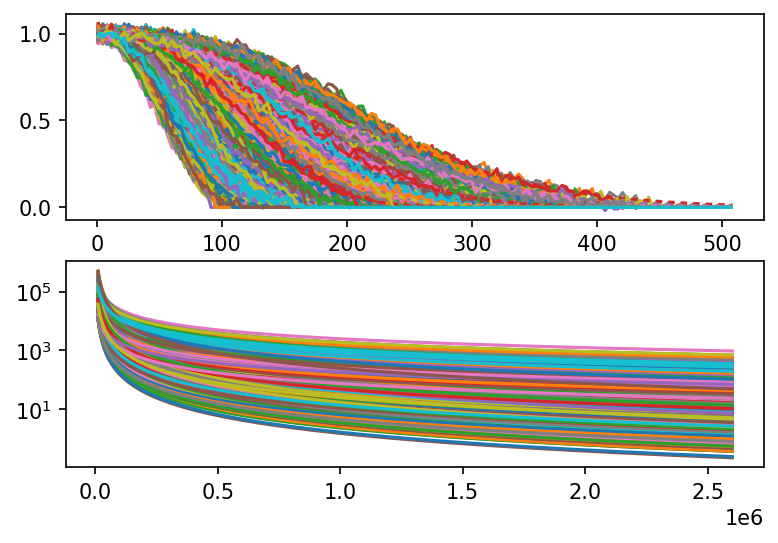

In [99]:
matplotlib.rcParams['figure.dpi']=150
n_plot = 500
rand_set = np.random.randint( 0, s_data_train.shape[0] ,(n_plot,) )
plt.subplot(2, 1, 1)
for i in range(n_plot):
    plt.plot(T_in*1e6,c_data_train[rand_set[i],:],label=f'{rand_set[i]}',dashes=[2,2,2,2],c="C"+str(i))
    plt.plot(T_train*1e6,c_train[rand_set[i],:],label=f'{rand_set[i]}',c="C"+str(i))
plt.subplot(2, 1, 2)
for i in range(n_plot):
    plt.plot(w_train,s_train[rand_set[i],:],label=f'{rand_set[i]}',c="C"+str(i))
plt.yscale('log')

ValueError: x and y must have same first dimension, but have shapes (5001,) and (301,)

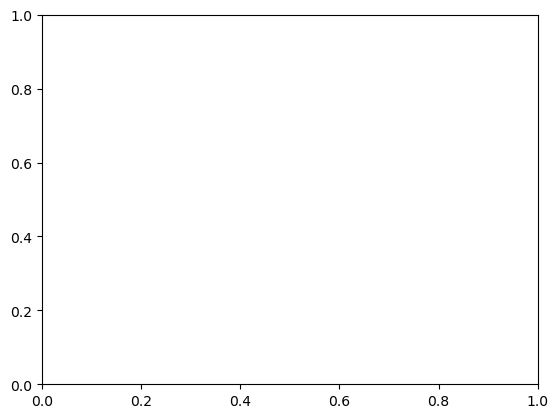

In [51]:
n_plot = 5
for i in range(n_plot):
    plt.plot(w0*1e6,c_data_test[rand_set[i],:],label=f'{rand_set[i]}',)
    plt.plot(w0,c_test[rand_set[i]],label=f'{rand_set[i]}')
    plt.yscale('log')

In [32]:
print("c_data = ",np.shape(c_data))
print("s_data = ",np.shape(s_data))
print("c_train = ",np.shape(c_train))
print("s_train = ",np.shape(s_train))

c_data =  (7281, 301)
s_data =  (7281, 5001)
c_train =  (7281, 147)
s_train =  (7281, 501)


In [80]:
2*np.pi/(2*1.2e-6)

2617993.8779914943

In [81]:
(2*1.2e-6)*1e6

2.4